### 画像データ、アノテーションデータへのファイルパスのリストを作成

In [8]:
import os.path as osp

In [9]:
def make_datapath_list(rootpath):
    
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')
    
    # 学習と検証、それぞれのファイルのID(ファイル名)を取得する
    train_id_names = osp.join(rootpath, 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath, 'ImageSets/Main/val.txt')
    
    # 学習データの画像ファイルとアノテーションファイルへのファイルパスを作成
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip() # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)   # 画像のパス
        anno_path = (annopath_template % file_id) # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
        
    # 検証データの画像ファイルとアノテーションファイルへのファイルパスを作成
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
        
    return train_img_list, train_anno_list, val_img_list, val_anno_list

動作確認

In [29]:
# ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml


### Datasetの作成

In [19]:
import numpy as np
import cv2
import torch
import torch.utils.data as data

In [55]:
# VOC2012のDatasetを作成
class VOCDataset(data.Dataset):
    """
        img_list       : 画像ファイルのパスを格納したリスト
        anno_list      : アノテーションへのパスを格納したリスト
        phase          : 'train' or 'val'
        transform      : 前処理クラスのインスタンス
        transform_anno : xmlアノテーションをリストに変換するインスタンス
    """
    
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
        
    def __len__(self):
        # 画像の枚数を返す
        return len(self.img_list) # 画像の枚数を返す
    
    def __getitem__(self, index):
        # 前処理をした画像テンソルとアノテーションを取得
        img, true_boxes_labels, h, w = self.pull_item(index)
        return img, true_boxes_labels
        
    def pull_item(self, index):
        # 1. 画像読み込み
        img_file_path = self.img_list[index]
        img = cv2.imread(img_file_path) # [高さ][幅][色BGR]
        height, width, channels = img.shape
        
        # 2. xml形式アノテーション情報をリストに変換
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        
        # 3. 前処理
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])
        # [高さ][幅][色BGR] -> [高さ][幅][色RGB] : numpy 元データの2軸目にあるBGRデータをRGBに変更
        img = img[:, :, (2,1,0)]
        # [高さ][幅][色RGB] -> [色RGB][高さ][幅] : pytorch 元データの2軸を0軸に移動
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        # BBoxとラベルをセットにしたnp.arrayを作成
        #print("pre-labels: {}".format(labels))
        labels = labels[:, None] # 1次元配列を2次元配列に変換
        true_boxes_labels = np.hstack((boxes, labels))
        #print("true_labels: {}".format(true_boxes_labels))
        
        return img, true_boxes_labels, height, width

動作確認

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Img-> size: torch.Size([3, 300, 300])
True_boxes_labels-> size: (2, 5), data: [[ 0.09        0.03003003  0.998       0.996997   18.        ]
 [ 0.122       0.56756757  0.164       0.72672673 14.        ]]


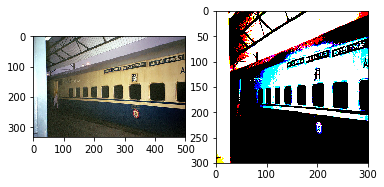

path: ./data/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg
height: 333, width: 500, channels: 3
[18. 14.]
['train', 'person']


In [56]:
# 1) ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 2) アノテーションのリストを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
                   'bottle', 'bus', 'car', 'cat', 'chair',
                   'cow', 'diningtable', 'dog', 'horse',
                   'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']
from SSD_convert_xml_annotation_data import Anno_xml2list
transform_anno = Anno_xml2list(voc_classes)

# 3) データオーグメンテーションを含む前処理の作成
color_mean = (104, 117, 123) # VOCデータセットの(BGR)平均
input_size = 300
from SSD_data_argmentation import DataTransform
transform = DataTransform(input_size, color_mean)

# 4) Pytorch用のデータセットを作成
train_dataset = VOCDataset(train_img_list, 
                           train_anno_list, 
                           phase='train',
                           transform=transform,
                           transform_anno=transform_anno)
val_dataset = VOCDataset(val_img_list,
                         val_anno_list,
                         phase='val',
                         transform=transform,
                         transform_anno=transform_anno)

# 5) データの取り出し例
index = 1
img, true_boxes_labels = val_dataset.__getitem__(index)
print("Img-> size: {}".format(img.shape))
print("True_boxes_labels-> size: {}, data: {}".format(true_boxes_labels.shape, true_boxes_labels))

# 6) 入力画像とその前処理結果
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cvImg = cv2.imread(val_img_list[index])
ax1.imshow(cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB))
from SSD_data_argmentation import ToCV2Image
cvtTensor2CVMat = ToCV2Image()
transformed_cvImg, _, _= cvtTensor2CVMat(img, None, None)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(cv2.cvtColor(transformed_cvImg, cv2.COLOR_BGR2RGB))
plt.show()

# 7) 利用した画像とアノテーションラベルの確認
image_file_path = val_img_list[index]
img = cv2.imread(image_file_path)
height, width, channels = img.shape
print("path: {}\nheight: {}, width: {}, channels: {}".format(image_file_path, 
                                                             height, 
                                                             width, 
                                                             channels))
labels = true_boxes_labels[:, -1]
print(labels)
class_names = []
for label in labels:
    class_names.append(voc_classes[int(label)])
print(class_names)